<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/crime_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 犯罪情報
- [町丁字別犯罪情報　令和３年分（累計値）](https://catalog.data.metro.tokyo.lg.jp/dataset/t000022d0000100001/resource/38bc69bc-3f83-4c70-af49-137c6b0db5e3)

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'crime_master.csv'
output_score_file = 'crime_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

In [7]:
crime_url = 'https://www.keishicho.metro.tokyo.lg.jp/about_mpd/jokyo_tokei/jokyo/ninchikensu.files/R3.csv'
df_crime = get_data_csv_url(crime_url, encoding='shift-jis')
print(df_crime.shape)

(5096, 38)


In [8]:
df_crime.columns

Index(['市区町丁', '総合計', '凶悪犯計', '凶悪犯強盗', '凶悪犯その他', '粗暴犯計', '粗暴犯凶器準備集合', '粗暴犯暴行',
       '粗暴犯傷害', '粗暴犯脅迫', '粗暴犯恐喝', '侵入窃盗計', '侵入窃盗金庫破り', '侵入窃盗学校荒し', '侵入窃盗事務所荒し',
       '侵入窃盗出店荒し', '侵入窃盗空き巣', '侵入窃盗忍込み', '侵入窃盗居空き', '侵入窃盗その他', '非侵入窃盗計',
       '非侵入窃盗自動車盗', '非侵入窃盗オートバイ盗', '非侵入窃盗自転車盗', '非侵入窃盗車上ねらい', '非侵入窃盗自販機ねらい',
       '非侵入窃盗工事場ねらい', '非侵入窃盗すり', '非侵入窃盗ひったくり', '非侵入窃盗置引き', '非侵入窃盗万引き',
       '非侵入窃盗その他', 'その他計', 'その他詐欺', 'その他占有離脱物横領', 'その他その他知能犯', 'その他賭博',
       'その他その他刑法犯'],
      dtype='object')

In [9]:
total_cols = [col for col in df_crime.columns if col.endswith('計')]
print(len(total_cols))

exclusion_rows = [row for row in list(df_crime['市区町丁'].unique()) if row.endswith('計')] + ['他県', '海外認知', '不明']
print(len(exclusion_rows))

6
67


In [10]:
df_crime_extract = df_crime[['市区町丁'] + total_cols]
df_crime_extract = df_crime_extract[~df_crime_extract['市区町丁'].isin(exclusion_rows)].reset_index(drop=True)
print(df_crime_extract.shape)

(5029, 7)


In [11]:
df_crime_extract['市区町村名'] = df_crime_extract['市区町丁'].str.extract('(^.*?[区市])', expand=False)
df_crime_ward = df_crime_extract[df_crime_extract['市区町村名'].fillna('').str.endswith('区')].reset_index(drop=True)
df_crime_ward['町丁目'] = df_crime_ward.apply(lambda x: x['市区町丁'].replace(x['市区町村名'], ''), axis=1)
print(df_crime_ward.shape)

assert df_crime_ward['市区町村名'].nunique() == 23

(3089, 9)


### 犯罪マスタ

In [12]:
df_crime_ward.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

### 人口マスタ

In [13]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目']]
print(df_pop_master.shape)

(2921, 4)


In [14]:
df_crime_master = pd.merge(
    df_pop_master, 
    df_crime_ward.drop(columns=['市区町丁']),
    on=['市区町村名', '町丁目'], how='left').fillna(0)
print(df_crime_master.shape)

(2921, 10)


In [15]:
df_crime_master.head()

,地域ID,市区町村名,町名,町丁目,総合計,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計
0,101003,千代田区,丸の内,丸の内１丁目,242.0,1.0,23.0,0.0,136.0,82.0
1,101004,千代田区,丸の内,丸の内２丁目,40.0,0.0,1.0,0.0,22.0,17.0
2,101005,千代田区,丸の内,丸の内３丁目,141.0,0.0,3.0,0.0,13.0,125.0
3,101007,千代田区,大手町,大手町１丁目,36.0,1.0,8.0,3.0,18.0,6.0
4,101008,千代田区,大手町,大手町２丁目,24.0,0.0,9.0,0.0,12.0,3.0


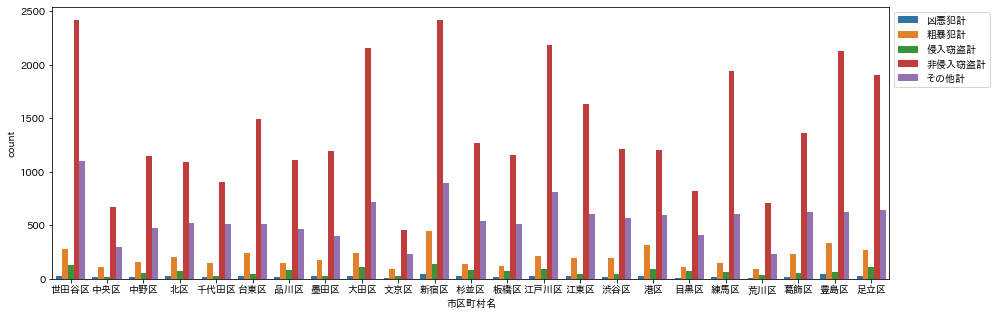

In [16]:
df_group_crime = df_crime_master.groupby('市区町村名')[['凶悪犯計', '粗暴犯計', '侵入窃盗計', '非侵入窃盗計', 'その他計']].sum().stack().rename('count').reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(data=df_group_crime, x='市区町村名', y='count', hue='level_1')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

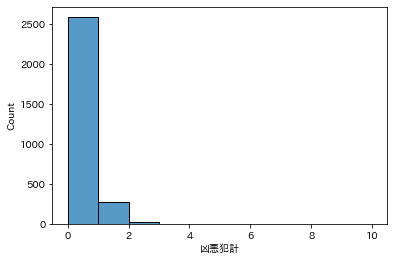

In [17]:
sns.histplot(df_crime_master['凶悪犯計'], bins=10)
plt.show()

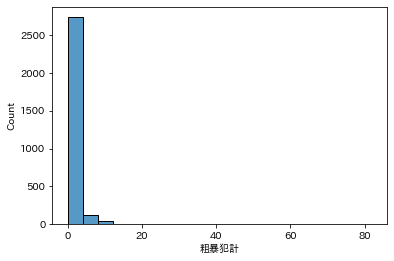

In [18]:
sns.histplot(df_crime_master['粗暴犯計'], bins=20)
plt.show()

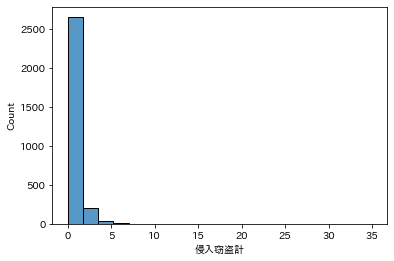

In [19]:
sns.histplot(df_crime_master['侵入窃盗計'], bins=20)
plt.show()

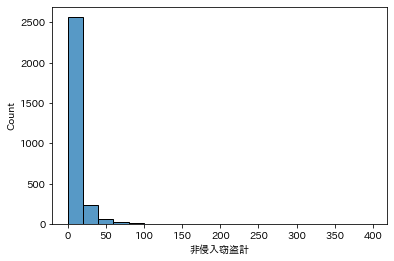

In [20]:
sns.histplot(df_crime_master['非侵入窃盗計'], bins=20)
plt.show()

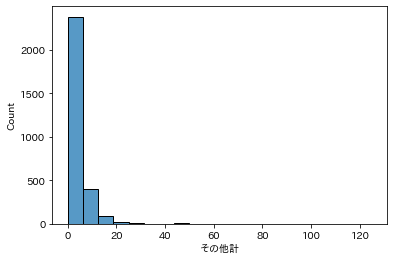

In [21]:
sns.histplot(df_crime_master['その他計'], bins=20)
plt.show()

In [22]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

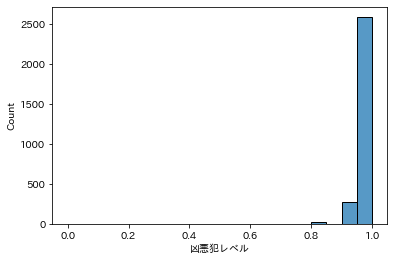

In [23]:
df_crime_master['凶悪犯レベル'] = normalize_score(df_crime_master['凶悪犯計'], high=False, outlier=False)
sns.histplot(df_crime_master['凶悪犯レベル'], bins=20)
plt.show()

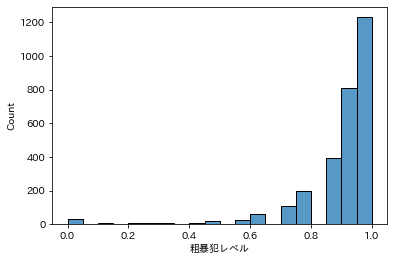

In [24]:
df_crime_master['粗暴犯レベル'] = normalize_score(df_crime_master['粗暴犯計'], high=False)
sns.histplot(df_crime_master['粗暴犯レベル'], bins=20)
plt.show()

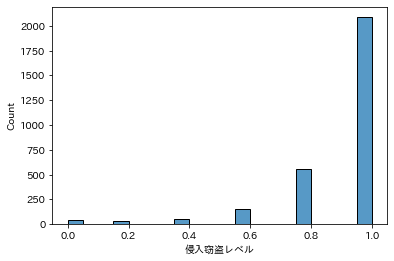

In [25]:
df_crime_master['侵入窃盗レベル'] = normalize_score(df_crime_master['侵入窃盗計'], high=False)
sns.histplot(df_crime_master['侵入窃盗レベル'], bins=20)
plt.show()

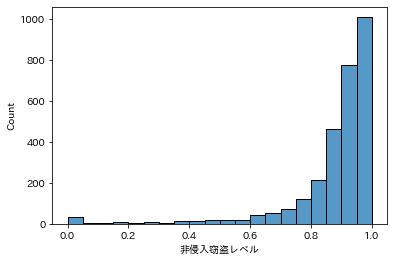

In [26]:
df_crime_master['非侵入窃盗レベル'] = normalize_score(df_crime_master['非侵入窃盗計'], high=False)
sns.histplot(df_crime_master['非侵入窃盗レベル'], bins=20)
plt.show()

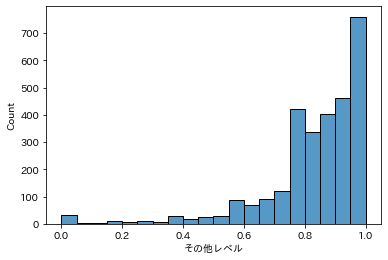

In [27]:
df_crime_master['その他レベル'] = normalize_score(df_crime_master['その他計'], high=False)
sns.histplot(df_crime_master['その他レベル'], bins=20)
plt.show()

In [28]:
score_list = [
    df_crime_master['凶悪犯レベル'] * 1.0,
    df_crime_master['粗暴犯レベル'] * 0.8,
    df_crime_master['侵入窃盗レベル'] * 0.6,
    df_crime_master['非侵入窃盗レベル'] * 0.5,
    df_crime_master['その他レベル'] * 0.4,
]
df_crime_master['_犯罪スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_crime_master['犯罪スコア'] = rank_score(df_crime_master['_犯罪スコア'])

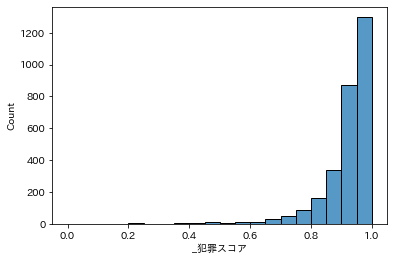

In [29]:
sns.histplot(df_crime_master['_犯罪スコア'], bins=20)
plt.show()

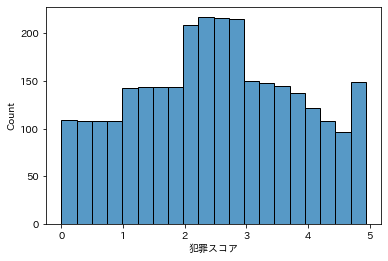

In [30]:
sns.histplot(df_crime_master['犯罪スコア'], bins=20)
plt.show()

In [31]:
df_crime_master[['地域ID', '市区町村名', '町丁目', '凶悪犯計', '粗暴犯計', '侵入窃盗計', '非侵入窃盗計', 'その他計', '_犯罪スコア', '犯罪スコア']]\
    .to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

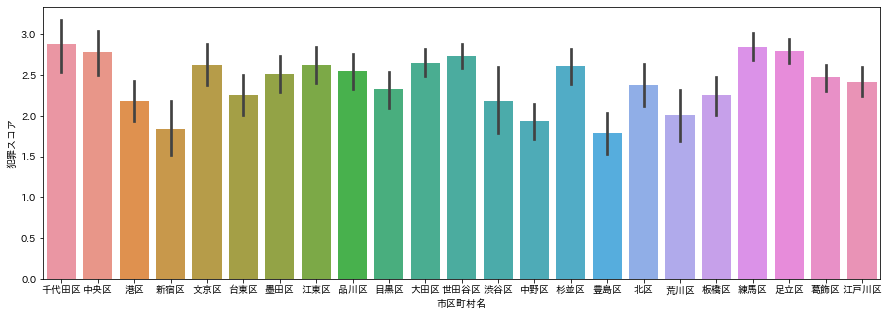

In [32]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='犯罪スコア', data=df_crime_master)
plt.show()

In [35]:
df_level = df_crime_master.copy()
df_level['rank'] = df_level.groupby('町名')['犯罪スコア'].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values('犯罪スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '犯罪スコア', '_犯罪スコア', '凶悪犯計', '粗暴犯計', '侵入窃盗計', '非侵入窃盗計', 'その他計']
].reset_index(drop=True)
print(df_level.shape)

(681, 10)


In [36]:
df_level.head(20)

,市区町村名,町名,町丁目,犯罪スコア,_犯罪スコア,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計
0,品川区,八潮,八潮１丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
1,足立区,東伊興,東伊興４丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
2,足立区,入谷,入谷６丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
3,足立区,古千谷,古千谷１丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
4,大田区,東海,東海５丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
5,大田区,京浜島,京浜島１丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
6,品川区,豊町,豊町３丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
7,品川区,小山,小山７丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
8,中央区,日本橋本石町,日本橋本石町３丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0
9,江東区,夢の島,夢の島１丁目,4.933813,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_level.tail(20)

,市区町村名,町名,町丁目,犯罪スコア,_犯罪スコア,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計
661,世田谷区,松原,松原６丁目,1.422544,0.892240,1.0,2.0,0.0,7.0,6.0
662,港区,高輪,高輪１丁目,1.417408,0.892170,0.0,3.0,0.0,6.0,9.0
663,葛飾区,亀有,亀有１丁目,1.388309,0.889574,1.0,1.0,0.0,10.0,9.0
664,千代田区,有楽町,有楽町２丁目,1.354074,0.886754,0.0,1.0,0.0,41.0,4.0
665,台東区,西浅草,西浅草１丁目,1.263352,0.881474,0.0,5.0,0.0,6.0,4.0
666,杉並区,阿佐谷南,阿佐谷南２丁目,1.134971,0.869958,1.0,2.0,0.0,19.0,6.0
667,中央区,新川,新川１丁目,1.039113,0.860249,0.0,1.0,1.0,12.0,13.0
668,千代田区,丸の内,丸の内２丁目,1.027131,0.858494,0.0,1.0,0.0,22.0,17.0
669,世田谷区,大原,大原１丁目,1.016861,0.857129,0.0,1.0,0.0,28.0,15.0
670,港区,西麻布,西麻布３丁目,0.960858,0.851830,0.0,4.0,0.0,13.0,11.0
